In [6]:
import numpy as np
import matplotlib.pyplot as plt

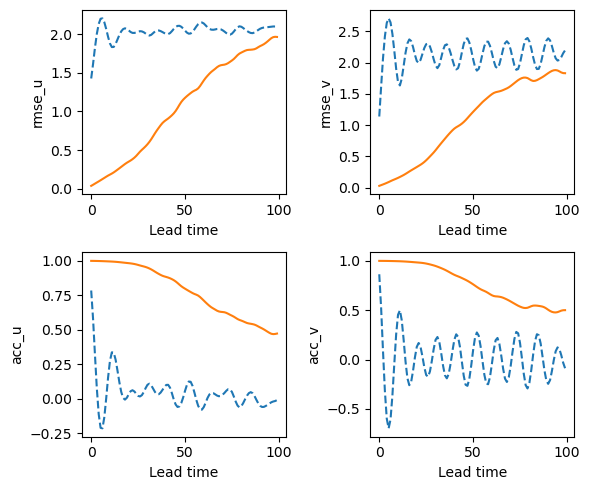

In [7]:
fname = '/glade/derecho/scratch/jshen/pruning-turbulence-vit/base/metrics.npz'
data = np.load(fname)

fig, axs = plt.subplots(2, 2, figsize=(6, 5), constrained_layout=True)

keys = ['rmse_u', 'rmse_v', 'acc_u', 'acc_v']
for ax, key in zip(axs.flatten(), keys):
    ax.plot(data[key + '_per'].mean(axis=0), linestyle='dashed')
    ax.plot(data[key].mean(axis=0))
    ax.set_xlabel('Lead time')
    ax.set_ylabel(key)

fig.tight_layout()